# Vulnerable record identification

In this notebook, we will use the tools as provided in the repo and the paper "Achilles' heels: Vulnerable Record Identification in Synthetic Data", to identify records vulnerable against MIAs for synthetic data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

import sys
sys.path.append('../')
from src.data_prep import read_data, read_metadata, discretize_dataset, normalize_cont_cols
from src.feature_extractors import fit_ohe, apply_ohe
from src.distance import compute_distances

## Load and preprocess the data

In [2]:
PATH_TO_DATA = '../data/Adult_dataset.csv'
PATH_TO_METADATA = '../data/Adult_metadata_discretized.json'

meta_data_og, categorical_cols, continuous_cols = read_metadata(PATH_TO_METADATA)
df = read_data(PATH_TO_DATA, categorical_cols, continuous_cols)
df = discretize_dataset(df, categorical_cols)
df = normalize_cont_cols(df, meta_data_og, df_aux = df, types = ('Float', 'Integer'))
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,0.301370,5,0.043350,9,0.800000,4,0,1,4,1,0.021740,0.0,0.397959,38,0
1,0.452055,4,0.047274,9,0.800000,2,3,0,4,1,0.000000,0.0,0.122449,38,0
2,0.287671,2,0.136877,11,0.533333,0,5,1,4,1,0.000000,0.0,0.397959,38,0
3,0.493151,2,0.149792,1,0.400000,2,5,0,2,1,0.000000,0.0,0.397959,38,0
4,0.150685,2,0.219998,9,0.800000,2,9,5,2,0,0.000000,0.0,0.397959,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,0.219178,2,0.156895,9,0.800000,4,9,3,4,1,0.000000,0.0,0.397959,38,0
45218,0.301370,2,0.136723,9,0.800000,0,9,1,4,0,0.000000,0.0,0.357143,38,0
45219,0.287671,2,0.244762,9,0.800000,2,9,0,4,1,0.000000,0.0,0.500000,38,0
45220,0.369863,2,0.047666,9,0.800000,0,0,3,1,1,0.054551,0.0,0.397959,38,0


## Fit the one hot encoding for the categorical attributes

In [3]:
ohe, ohe_column_names = fit_ohe(df, categorical_cols, meta_data_og)
df_ohe = apply_ohe(df.copy(), ohe, categorical_cols, ohe_column_names, continuous_cols)
df_ohe

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_0,workclass_1,workclass_2,workclass_3,...,native-country_33,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,salary_0,salary_1
0,0.301370,0.043350,0.800000,0.021740,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.452055,0.047274,0.800000,0.000000,0.0,0.122449,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.287671,0.136877,0.533333,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.493151,0.149792,0.400000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.150685,0.219998,0.800000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,0.219178,0.156895,0.800000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45218,0.301370,0.136723,0.800000,0.000000,0.0,0.357143,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45219,0.287671,0.244762,0.800000,0.000000,0.0,0.500000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
45220,0.369863,0.047666,0.800000,0.054551,0.0,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Compute the distances

We can now compute all distances between all records. Note that in the paper we did this for all records in the dataset, but for the purpose of this demo (computational reasons) we compute the most vulnerable records within a subset of this. 

The records used in the paper were: [39435, 1678, 35988, 36838, 6066, 27566, 16525, 43082, 5918, 16249]. 

Let's artifically add these records so we recover the same in this demo. 

In [6]:
records_paper = [39435, 1678, 35988, 36838, 6066, 27566, 16525, 43082, 5918, 16249]
sub_df_paper = df_ohe.loc[records_paper]

In [13]:
sample_df = df_ohe[~df_ohe.index.isin(records_paper)].sample(10000 - 10)
sub_df_ohe = pd.concat([sample_df, sub_df_paper])
sub_df_ohe

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_0,workclass_1,workclass_2,workclass_3,...,native-country_33,native-country_34,native-country_35,native-country_36,native-country_37,native-country_38,native-country_39,native-country_40,salary_0,salary_1
41426,0.123288,0.078058,0.600000,0.000000,0.000000,0.397959,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
27835,0.095890,0.136129,0.600000,0.000000,0.000000,0.602041,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15712,0.369863,0.135926,0.600000,0.000000,0.000000,0.500000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4965,0.575342,0.020129,0.600000,0.000000,0.000000,0.428571,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
19745,0.054795,0.175983,0.666667,0.000000,0.000000,0.500000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27566,0.547945,0.071307,0.066667,0.000000,0.367769,0.448980,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16525,0.164384,0.222207,0.533333,0.000000,0.359045,0.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
43082,0.506849,0.054730,0.266667,0.000000,0.496556,0.142857,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5918,0.136986,0.133752,0.000000,0.413104,0.000000,0.234694,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
# get the right indices for the distance computation
all_columns = list(sub_df_ohe.columns)
ohe_cat_indices = [all_columns.index(col) for col in ohe_column_names]
continous_indices = [all_columns.index(col) for col in continuous_cols]

# make sure to save the computed distances
ALL_DISTANCES = dict() 
N_TO_SAVE = 100
DISTANCE_METHOD = 'cosine'

df_ohe_values = sub_df_ohe.values
targets = sub_df_ohe.index

for i, target_id in tqdm(enumerate(targets)):
    target_record = sub_df_ohe.loc[target_id].values
    distances_target = compute_distances(record=target_record, values=df_ohe_values, 
                                         ohe_cat_indices=ohe_cat_indices, continous_indices=continous_indices,
                                         n_cat_cols=len(categorical_cols), n_cont_cols=len(continuous_cols),
                                         method = DISTANCE_METHOD)

    # let's sort it already
    ALL_DISTANCES[target_id] = np.sort(distances_target)[:N_TO_SAVE]

10000it [01:53, 87.90it/s]


## Identify the vulnerable records
    
We'll now compute, for each record, the mean distance to its 5 closest neighbors. The records for which this distance is the largest are considered the vulnerable ones. 

In [15]:
K_NEIGHBORS = 5

mean_distance_top_5 = dict()
for target_id in ALL_DISTANCES.keys():
    mean_distance_top_5[target_id] = np.mean(ALL_DISTANCES[target_id][:K_NEIGHBORS])

Text(0.5, 1.0, 'Distribution of mean distances of 5 closest points in sub df')

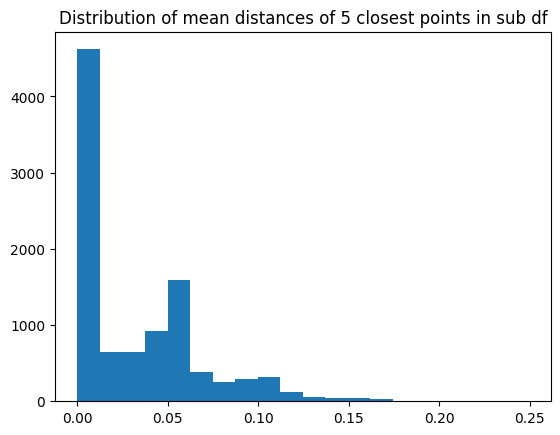

In [16]:
plt.figure()
plt.hist(mean_distance_top_5.values(), bins = 20)
plt.title('Distribution of mean distances of 5 closest points in sub df')

In [17]:
# Identify 10 vulnerable records by taking the 10 records with the greatest value
sorted_key_vals = sorted(mean_distance_top_5.items(), key=lambda x:x[1], reverse = True)
vulnerable_records = [k[0] for k in sorted_key_vals[:10]]
print(vulnerable_records)

[16525, 5918, 27566, 39435, 35988, 36838, 1678, 43082, 16249, 6066]


In [18]:
# let's check the overlap of the records used in the paper and the ones recovered here
n_overlap = len(set(vulnerable_records).intersection(set(records_paper)))
print(f'Found {n_overlap} overlapping records and {10 - n_overlap} new record(s).')

Found 10 overlapping records and 0 new record(s).
